In [7]:
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn')

Support vector machines are versatile ML models that can be used for linear or non-linear classification, regression and even outlier detection.

They are particularly well-suited to complex small/medium sized datasets

# Linear SVM Classification

We'll start our discussion by looking at some images. They will help us explain the fundamental idea behind SVMs.

As in the previous chapter we'll use the iris dataset. Consider the plot below which shows decision boundaries of three possible linear classifiers.

*snippet taken from github.com/ageron/handson-ml2 *

In [9]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris['data'][:, (2,3)] # petal length, petal width
y = iris['target']

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

svm_clf = SVC(kernel='linear', C=float('inf'))
svm_clf.fit(X,y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

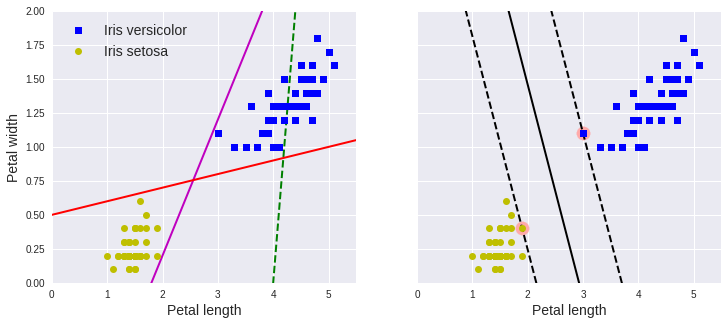

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

plt.sca(axes[0]) # set current axes
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

From the positioning of the dots and squares, it is easy to see that these two classes are linearly separable.

On the left, the green dashed line does a poor job of separating the classed. In contrast both the magenta and red line do a good job of classifying the training set, but the boundary is so close to the training instances that it might perform poorly on new instances.

The model on the right (an SVM) finds a line that not only separates the two classes, but also tries to stay away as far as possible from the instances. By fitting the widest margin possible, we're doing *large margin classification*.

The margins are fully defind by the training instances lying on the boundaries. These are called **support vectors**. (circled in pink in the image above)

**NOTE:** SVMs are very sensitive to feature scales! Always scale your data before fitting a SVM. (example on pg. 154)

### Hard vs Soft Margin

Because there's an area between decision boundaries, we can specify how the model approaches constructing the boundaries. If we impose that all instances must be outside the boundaries and on the correct classes we are imposing *hard margin classification*.

While it specifies a stricter model, this approach has two main problems:
- Only works if the data is linearly separable
- Sensitive to outliers

Take the two plots below as an example

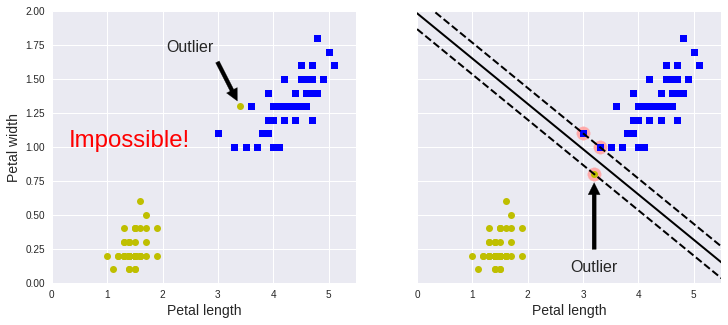

In [24]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

On the left, it is impossible to find a hard margin. On the right the decision boundaries are very different from the one above and probably won't generalize well.

To overcome these, we can take a more flexible approach and allow for *margin violations* (i.e. instances that are on the wrong side or between the boundaries). 

Margin violations are bad, thus we try to minimize them. With a **soft margin classifier** we try to find a balance between having a large distance between the boundaries while minimizing the number of margin violations.

In sklearn, the hyperparameter C is in control of regularization. If the SVM is overfitting,  we can try reducing the value of C. *(see page 155 for plot with different values of C)*

Here's our first example to detect iris virginica flowers

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X = iris['data'][:, (2,3)] # reload petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # iris virginica

svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])
svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [32]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

*Notes*

Instead of LinearSVC we could've used SVC(kernel='linear', C=1) or SGDClassifier(loss='hinge', alpha=1/(m\*C)). The latter uses SGD and while slower to converge, it can be used for online training and out-of-core training.

- SVMs do not output class probabilities, but an actual class.
- *LinearSVC* regularizes the bias term, so the data should be centered (by subtracting the mean, for example using StandardScaler). 
- Set the loss hyperparameter to hinge as it is not the default
- For better performance, set dual=False, unless there are more features than training instances

# Non-linear SVM Classification

While linear SVM classifiers are efficient, it is often the case that our data is not linearly separable. One approach to handling these datasets, is to add more features. (see fig 5-5 pg 157).

We'll implement this idea by using the moons dataset by implementing a pipeline using a PolynomialFeatures transformer, followed by a scaler and a linearSVC. The moons dataset is a toy dataset where the data is shaped as two interleaving half circles.

In [85]:
def plot_dataset(X, y, axes):
    plt.plot(X[y==0][:, 0], X[y==0][:, 1], 'bo')
    plt.plot(X[y==1][:, 0], X[y==1][:, 1], 'go')
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

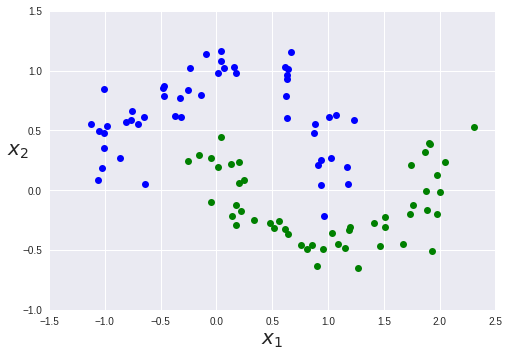

In [101]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15 )
axes = [-1.5, 2.5, -1, 1.5]
plot_dataset(X,y, axes)
plt.show()

In [102]:
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scale', StandardScaler()),
    ('linear_svm', LinearSVC(C=10, loss='hinge'))
])
polynomial_svm_clf.fit(X, y)

/home/carlos/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svm',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [103]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 300)
    x1s = np.linspace(axes[0], axes[3], 300)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

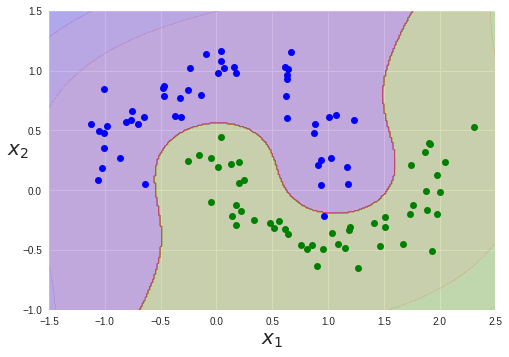

In [104]:
plot_predictions(polynomial_svm_clf, axes)
plot_dataset(X, y, axes)
plt.show()

## Polynomial Kernel

Polynomial features are useful and can be used for various models. However at a low degree, it won't handle complex datasets and at very high degrees, it adds lots of features making the model too slow.

SVMs allow us to use a kernel trick (see below), which yields the same result as if we used many polynomial features but without actually having to add them.

Below we train two models, one with degree 3 and other with degree 10 and plot their results. The parameter coef0 controls how much the model is influenced by high-degree polynomial vs low-degree polynomials.

In [95]:
# Polynomial kernel of degree 3
poly3_kernel_svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly3_kernel_svm_clf.fit(X, y)

# Polynomial kernel of degree 10
poly10_kernel_svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=100, C=5))
])
poly10_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

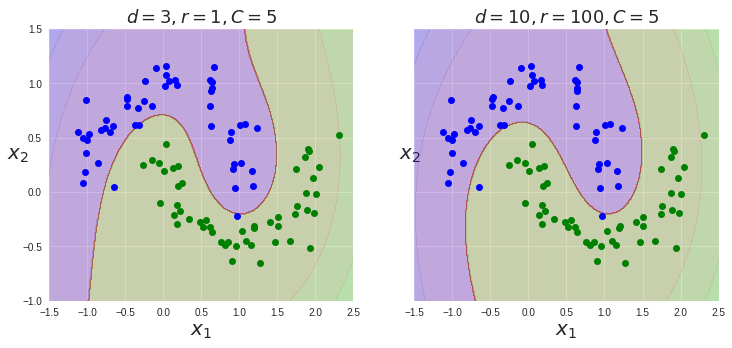

In [106]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, sharey=True)

plt.sca(ax[0])
plot_predictions(poly3_kernel_svm_clf, axes)
plot_dataset(X, y, axes)
plt.title(r'$d = 3, r = 1, C = 5$', fontsize=18)

plt.sca(ax[1])
plot_predictions(poly10_kernel_svm_clf, axes)
plot_dataset(X, y, axes)
plt.title('$d = 10, r = 100, C = 5$', fontsize=18)

plt.show()

GridSearch is perfect for optimizing hyperparameters!

### Similiarity Features